# Accessing GBIF Parquet data on Azure and AWS clouds using duckdb

In [5]:
import pystac_client
import planetary_computer

import duckdb
import adlfs

## Azure

Using Planetary Computer, we can query STAC to access GBIF snapshots on Azure

In [6]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
search = catalog.search(collections=["gbif"])
items = search.get_all_items()
items = {x.id: x for x in items}

# most recent snapshot (first item)
item = list(items.values())[0]

In [7]:
keys = item.assets["data"].extra_fields["table:storage_options"]
AZURE_STORAGE_ACCOUNT_NAME = keys["account_name"] 
AZURE_STORAGE_ACCOUNT_KEY = keys["credential"]

In [8]:
fs = adlfs.AzureBlobFileSystem(account_name=AZURE_STORAGE_ACCOUNT_NAME, account_key=AZURE_STORAGE_ACCOUNT_KEY )
con = duckdb.connect()
con.register_filesystem(fs)

In [ ]:
# test with trivial query
df = con.execute(f'''
    SELECT *
    FROM read_parquet("abfs://gbif/occurrence/2023-02-01/occurrence.parquet/*")
    LIMIT 1
    '''
).df()

df

Count vertebrate species by class in each .1 degree pixel

In [1]:



query = f'''
SELECT class, longitude, latitude, COALESCE(n, 0.0) AS n
FROM (
  SELECT class, longitude, latitude, COUNT(*) AS n
  FROM (
    SELECT DISTINCT
      class,
      genus,
      ROUND(decimallongitude,1) AS longitude,
      ROUND(decimallatitude, 1) AS latitude
    FROM read_parquet("abfs://gbif/occurrence/2023-02-01/occurrence.parquet/*")
    WHERE (phylum = 'Chordata')
  )
  GROUP BY class, longitude, latitude
)
'''
df = con.execute(query).df()


NameError: name 'con' is not defined

In [ ]:
import geopandas as gpd
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_points_griddata, rasterize_points_radial

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs='epsg:4326')
geo_grid = make_geocube(
    vector_data=gdf,
    measurements=['n'],
    resolution=.1,
    rasterize_function=rasterize_points_griddata,
)

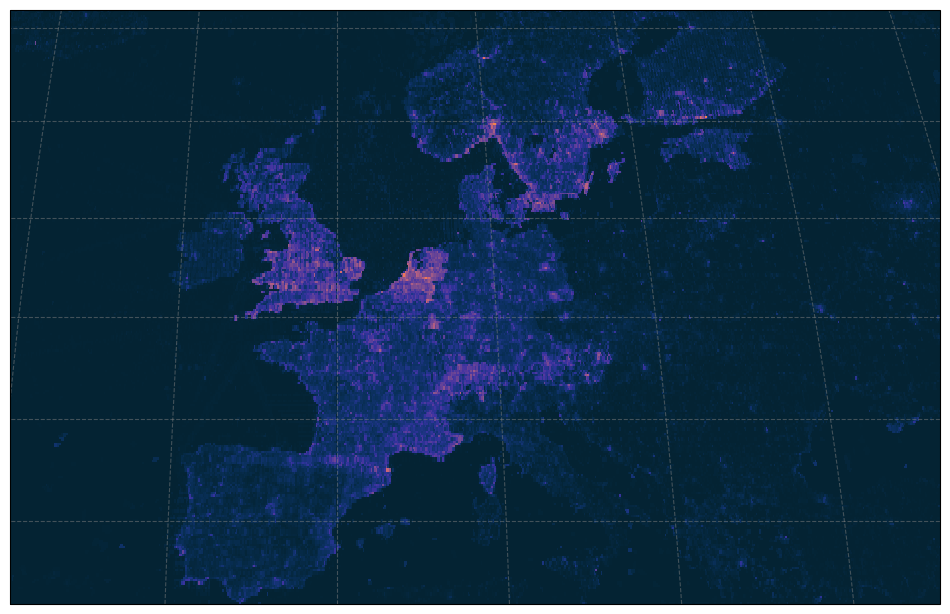

In [21]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

subplot_kws=dict(projection=ccrs.Robinson(),
                 facecolor='grey')

plt.figure(figsize=[12,8])
p = geo_grid.n.plot(cmap='viridis',
                  subplot_kws=subplot_kws,
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False)

p.axes.gridlines(color='grey', alpha=0.5, linestyle='--')
p.axes.set_extent([-19, 35, 30, 66], crs=ccrs.PlateCarree())
